In [1]:
from src.eda_vector import *
from src.lda_model import *
from src.model import *
from src.classifier import *
from src.helpers import *
from imblearn.over_sampling import SMOTE

In [2]:
'''
NOTE: No EDA appears in this notebook. See Untitled-Copy2 for EDA
--> EDA methods also availible in EDA_vec class
'''
print()

In [3]:
# train, test, split
X_train, X_test, y_train, y_test = get_data(num_samples=50000)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [4]:
# vectorizing process
custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
                'trump', 'clinton', 'donald', 'donald trump', 'donaldtrump', 'says', 'hillary', 'hillaryclinton',
                'hillary clinton', 'realdonaldtrump', 'would', 'let', 'video', 'like']

# custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
#                 'says', 'would', 'let', 'video', 'like']

# fit vectorizer, add stop words, return vocab
vectors = EDA_vec(X_train, y_train)
vectors.add_stop_words(custom_stops)
vocab, fit_mat = vectors.vectorize(min_df=0.0001)

# transform traininng and testing data 
matrix = fit_mat.transform(X_train)
matrix_test = fit_mat.transform(X_test)

In [5]:
vectors.legit_count, vectors.troll_count

(34500, 3000)

In [6]:
matrix.shape, matrix_test.shape

((37500, 17656), (12500, 17656))

In [7]:
# fit LDA model on training data
lda = LDA_model(topics=35)
lda.fit(matrix, y_train, vocab)
lda.phi() # to evaluate coherence score
theta = lda.theta()

# get test theta for random forest evaluation
theta_test = lda.test_theta(matrix_test)

In [8]:
# random forest parameters
estimators = 1000
depth = 200
leafs = 100
th_hold = 0.75

In [9]:
# balance data from LDA theata matrix
y_smote = y_train
theta, y_train = SMOTE().fit_resample(theta, y_train)

In [11]:
from sklearn.metrics import f1_score

Random Forest Scores -- with LDA
accuracy = 0.91536
oob = 0.9002608695652173
recall = 0.011
precision = 0.1375


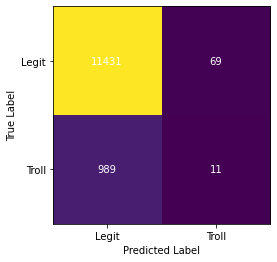

In [10]:
# random forest (with LDA)
forest = RandForest(n_estimators=estimators, max_depth=depth, max_leaf=leafs, 
                    max_features=theta.shape[1], class_weight='balanced')
forest.fit(theta, y_train)
probas, y_hat = forest.predict(theta_test, thresh=th_hold)
forest.score(y_test, y_hat)
print('Random Forest Scores -- with LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

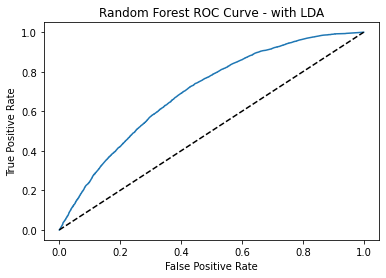

In [16]:
thresh = plot_roc_curve(theta, y_train, lda=True) # with LDA

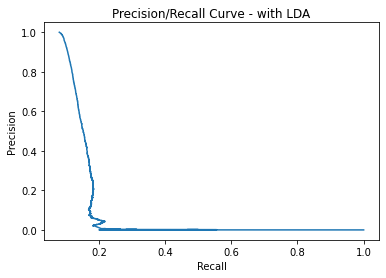

In [15]:
pr_thresh = plot_prec_rec_curve(theta, y_train, lda=True)

In [11]:
# balance data from count vectorized data
matrix, y_train = SMOTE().fit_resample(matrix, y_smote) # y_smote saved version of y_test before LDA smote changed variable

Random Forest Scores -- w/out LDA
accuracy = 0.92
oob = 0.8733623188405797
recall = 0.0
precision = 0.0


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


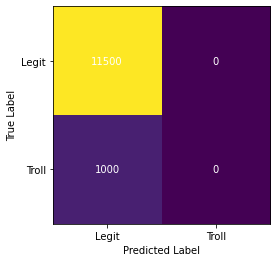

In [12]:
# random forest (without LDA)
forest = RandForest(n_estimators=estimators, max_depth=depth, max_leaf=leafs, 
                    max_features='log2', class_weight='balanced')
forest.fit(matrix, y_train)
probas, y_hat = forest.predict(matrix_test, thresh=th_hold)
forest.score(y_test, y_hat)
print('Random Forest Scores -- w/out LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

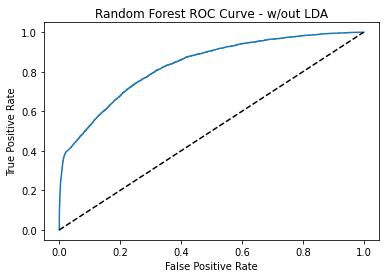

In [14]:
thresh_nolda = plot_roc_curve(matrix, y_train, lda=False) # wihtout LDA

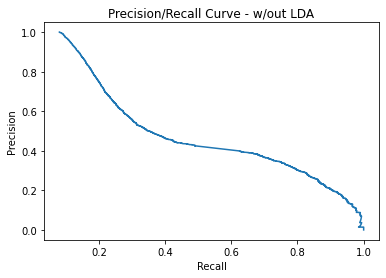

In [13]:
pr_thresh_nolda = plot_prec_rec_curve(matrix, y_train, lda=False)

In [11]:
lda.display_topics()

Topic 0:
going watch back tax white rally got show campaign much
Topic 1:
election campaign gop win day right president polls voters poll
Topic 2:
time america vote people know khan every way never take
Topic 3:
obama debate man women bill presidential debatenight vote still speech
Topic 4:
us president cnn think even taxes family know lies people


In [12]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split

def plot_roc_curve(X, y, lda=False, n_estimators=1000, max_depth=100, max_leaf=None):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25, 
                                                        shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = RandForest(n_estimators=n_estimators, max_depth=max_depth, 
                            max_leaf=max_leaf, max_features=X.shape[1])
    model.fit(X_train, y_train)
    probas, y_hat = model.predict(X_test, thresh=-1)
    fpr, tpr, thresh = roc_curve(y_test, probas[:,1])
    
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], ls='--', color='k')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    if lda:
        ax.set_title(f'Random Forest ROC Curve - with LDA')
    else:
        ax.set_title(f'Random Forest ROC Curve - w/out LDA')
    
    return thresh

def plot_prec_rec_curve(X, y, lda=False, n_estimators=1000, max_depth=100, max_leaf=None, thresh=-1):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25, 
                                                        shuffle=True, stratify=y)
    fig, ax = plt.subplots()
    
    model = RandForest(n_estimators=n_estimators, max_depth=max_depth, 
                            max_leaf=max_leaf, max_features=X.shape[1])
    model.fit(X_train, y_train)
    probas, y_hat = model.predict(X_test, thresh=thresh)
    precision, recall, thresh = precision_recall_curve(y_test, probas[:,1])
    
    ax.plot(precision, recall)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    if lda:
        ax.set_title(f'Precision/Recall Curve - with LDA')
    else:
        ax.set_title(f'Precision/Recall Curve - w/out LDA')
    
    return thresh

In [16]:
lda.coherance_score()

-5.237078828221568

In [31]:
lda.coherance_score()

-4.748669717009582

In [ ]:
'''TOPIC COHERANCE SCORES: --> only 10k data samples'''
# topics 2 --> -7.487219089117191
# topics 4 --> -10.222697013007569
# topics 6 --> -12.070494413320219
# topics 8 --> -13.165411752758045
# topics 10 --> -13.466351137344793
# topics 12 --> -14.279565234962526
# topics 14 --> -14.610241988703596
# topics 18 --> -15.333867297657738
# topics 20 --> -15.802765426002347
# topics 22 --> -15.90626134524627
# topics 24 --> -16.21720655745143
# topics 26 --> -15.494214848919107

In [17]:
# test for best num_topics:

def test_topics(X, y, vocab, low, high, by):
    scores = []
    
    for n_topic in range(low, high, by):
        lda = LDA_model(topics=n_topic)
        lda.fit(X, y, vocab)
        lda.phi()
        score = lda.coherance_score()
        scores.append((n_topic, score))
        
    return scores

def print_topic_score(scores):
    for score in scores:
        print(f'#{score[0]} --> {score[1]}')
        
def plot_topic_scores(scores):
    fig, ax = plt.subplots()
    x = [n_topics[0] for n_topics in scores]
    y = [score[1] for score in scores]
    
    ax.plot(x, y)
    ax.set_title('Coherence Score by Topic')
    ax.set_xlabel('# of Topics')
    ax.set_ylabel('Coherence Score');

In [ ]:
topic_scores = test_topics(matrix, y_train, vocab, 2, 30, 2)

In [ ]:
print_topic_scores(topic_scores)

In [ ]:
plot_topic_scores(topic_scores)

In [89]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, plot_confusion_matrix

# Random Forest, X = theta, y = y_train
def eval_random_forest(X, y, folds=15, n_estimators=500, max_depth=15, max_leaf=None):
    
    kf = KFold(n_splits=folds, shuffle=True)
    accur = []
    oob_  = []
    rec   = []
    prec  = []
    f_1   = []
    iters = 0
    
    for train, test in kf.split(X):
        
        # random forest 
        forest = RandForest(n_estimators=n_estimators, max_depth=max_depth, 
                            max_leaf=max_leaf, max_features=theta.shape[1])
        forest.fit(X[train], y.iloc[train])
        probas, y_hat = forest.predict(X[test])
        forest.score(y.iloc[test], y_hat)
        
        accur.append(forest.acc)
        oob_.append(forest.oob)
        rec.append(forest.recall)
        prec.append(forest.precision)
        f_1.append(forest.f_one)
        
        iters += 1
        if iters % 5 == 0:
            print(iters)
        
    
    return np.mean(accur), np.mean(oob_), np.mean(rec), np.mean(prec), np.mean(f_1), forest

In [90]:
accuracy, mean, rec, prec, model = eval_random_forest(theta, y_train)

5
10
15


In [ ]:
'''
Evaluate best number of estimators, leafs, and max_depth
'''
def test_forest_depth(X, y, depth_lst):
    accuracy = []
    for depth in depth_lst:
        accuracy.append(eval_random_forest(X, y, max_depth=depth))
        
    return accuracy

def test_forest_estimators(X, y, est_lst):
    accuracy = []
    for est in est_lst:
        accuracy.append(eval_random_forest(X, y, n_estimators=est, max_depth=50))
        
    return accuracy

def test_max_leafs(X, y, leaf_lst):
    accuracy = []
    for leaf in leaf_lst:
        accuracy.append(eval_random_forest(X, y, max_leaf=leaf))
        
    return accuracy

def plot_folds_random_forest_folds(X, y, fold_lst):
    fig, ax = plt.subplots()
    xs = fold_lst
    ys = test_forest_folds(X, y, fold_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Folds')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Folds');
    
def plot_depth_random_forest(X, y, depth_lst):
    fig, ax = plt.subplots()
    xs = depth_lst
    ys = test_forest_depth(X, y, depth_lst)
    ax.plot(xs, ys)
    ax.set_title('Random Forest Accuracy by Depth')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Depth');
